# Photoreceptor segmentation using [napari](https://napari.org/) and [cellpose](https://cellpose-napari.readthedocs.io/en/latest/index.html)

### Basic usage:
```python
viewer = napari.Viewer()
nbscreenshot(viewer)
viewer.close()
```

example notebooks [here](https://github.com/sofroniewn/napari-training-course/blob/master/lessons/)

In [2]:
# !mamba install -c conda-forge devbio-napari --yes
# !jupyter labextension list
# !mamba install -c conda-forge cellpose-napari --yes
# from cellpose import models

ModuleNotFoundError: No module named 'cellpose'

In [1]:
# image analysis
import napari
from magicgui import magicgui
from enum import Enum
import cellpose_napari
import cellpose
from cellpose import models
from tifffile import imread
import napari_nikon_nd2
from skimage.io import imread
from magicgui import magicgui
# python basics and plotting
import numpy as np
import pandas as pd
import math
from scipy import ndimage
from scipy.stats import kruskal
from scipy.stats import zscore
from scipy.stats import sem
import scikit_posthocs
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import svgutils
from svgutils.compose import *
# system interaction
import os.path
import time, sys, warnings, re
from tqdm.notebook import tqdm, trange
import importlib
import ipywidgets
from IPython.display import display
# lab brews
from plotParams import *
from lloyd import *


def getFileList(dirData,gene,fileNameMatch,addDetails=''):
   fileList = sorted([f for f in os.listdir(dirData) if not f.startswith('.')]) # get all the files in the data directory (excluding system files) and sort them alphabatically
   fileList = ([f for f in fileList if gene in f]) # select files that match the gene of interest
   fileList = ([f for f in fileList if any([s in f for s in fileNameMatch])]) # only keep relevant files
   if (addDetails=='path'):
      fileList = (['# filePath = \'' + f for f in fileList]) # add text before each file
      fileList = list(map(lambda st: str.replace(st, '.nd2', '\'; gene = \'' + gene + '\'; '), fileList)) #remove file extension (.nd2) and add text after each file
   elif (addDetails=='list'):
      fileList = (['\'' + f for f in fileList]) # add text before each file
      fileList = list(map(lambda st: str.replace(st, '.nd2', '\','), fileList)) #remove file extension (.nd2) and add text after each file
   else:
      fileList = list(map(lambda st: str.replace(st, '.nd2', ''), fileList)) #remove file extension (.nd2) and add text after each file
   return fileList


pBGMenu = ipywidgets.Dropdown(options=['Light', 'Dark'],value='Dark',disabled=False, layout=ipywidgets.Layout(width='20%', height='40px'))
pBGLabel = ipywidgets.widgets.Label('Select plotting style', layout=ipywidgets.Layout(width='20%', height='30px'))
pBG = ipywidgets.widgets.VBox([pBGLabel,pBGMenu])
pBG

In [2]:
applyPlotStyle(pBGMenu.value)
viewer = napari.Viewer()

Plotting style is Dark


In [59]:
viewer = napari.Viewer()

In [131]:
        viewer.close()

***
# Index <a id='Index'></a>
***
- [define directories](#dirDef)
- [Extraction of z planes for analysis](#zExtract)
- [Segmentation with cellpose](#cellSeg)
- [Manual correction of segmentation](#manualCuration)
- [Create thumbnails _WIP_](#thumbnails)
- [Quantification](#quantification)

***
## Define directories<a id='dirDefdirDef'>∮</a>
***
[Back to Index](#Index)

In [4]:
# define where all the imaging data is stored
dirData = 'D:/Imaging/20250202_2bhetinx_s2C_m2G/'
# define where all the analysis files should be stored
# subdirectories for each gene and transgenic lines need to be manually made first
dirAnalysis = "D:/Analysis/20250202_Tbx2bhetinx_m2Gs2C/m2Gs2C/"

# # define where all the imaging data is stored
# dirData = 'D:/Imaging/0250202_2bhetinx_s2C_m2G/'
# # define where all the analysis files should be stored
# # subdirectories for each gene and transgenic lines need to be manually made first
# dirAnalysis = 'D:/Analysis/20250202_Tbx2bhetinx_m2Gs2C/m2Gs2C/'

In [5]:
gene = '' # usually 'wt' or gene of interest (e.g. 'tbx2a', 'lhx1a')
# gene = 'lhx1a' # usually 'wt' or gene of interest (e.g. 'tbx2a', 'lhx1a')
fileNameMatch = ['002','004'] # characters in filenames that define zoom-in files

# get a list with all the relevant files
print(*getFileList(dirData,gene,fileNameMatch,addDetails='path'), sep = "\n") #display the file list for copy and paste below

# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_004'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_002'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_004'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_002'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_004'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_002'; gene = ''; 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_004'; gene = ''; 
# filePath = '202501

***
## Extract layers from z-stacks<a id='zExtract'>∮</a>
> Open z-stack &rarr; Pick limits in z for Maximum-Intensity Projection (_MIP_) &rarr; save MIPs &rarr; Ensure image was located in central retina
***
[Back to Index](#Index)

In [27]:
# clear viewer if needed
viewer.layers.select_all()
viewer.layers.remove_selected()

In [6]:
# clear viewer before any loading
viewer.layers.select_all()
viewer.layers.remove_selected()

# open files one by one (by commenting and uncommenting each one)

#uninj
filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002'; gene = ''; zlims = [23,25]; #beautifulexampleimage - WT
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004'; gene = ''; zlims = [19,21];#beautifulexampleimage - WT
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002'; gene = ''; zlims = [19,21];
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004'; gene = ''; zlims = [22,23];
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002'; gene = ''; zlims = [24,26]; #DEF LOOKS MUT
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004'; gene = ''; zlims = [21,23]; #LOOKS MUT - OMIT
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002'; gene = ''; zlims = [8,11]; #zoominnotflat
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_004'; gene = ''; zlims = [16,18]; #Not very good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_002'; gene = ''; zlims = [17,19]; #beautiful
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_004'; gene = ''; zlims = [4,21]; #looks good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_002'; gene = ''; zlims = [16,21]; #DAPI not representative
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_004'; gene = ''; zlims = [19,21]; # very good - wt looking
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_002'; gene = ''; zlims = [23,33]; #looks good 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_004'; gene = ''; zlims = [13,18]; #looks good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_002'; gene = ''; zlims = [36,41]; #looks good 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_004'; gene = ''; zlims = [16,25]; #super good dapi
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L09_004'; gene = ''; zlims = [19,35]; #good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_002'; gene = ''; zlims = [31,36]; #good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_004'; gene = ''; zlims = [25,33]; #good 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_002'; gene = ''; zlims = [20,33]; #good 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004'; gene = ''; zlims = [14,19]; #might be rods - reccheck and omit?

layerNames = ['M', 'S', 'N']
# layerNames = ['R', 'U', 'PNA', 'N']
# layerNames = ['N', 'U']

# create subdirectory for analysis output
dirOut = dirAnalysis + gene + '/' + filePath + '/'
if (os.path.isdir(dirOut)==False):
   os.mkdir(dirOut)
   print('Created output directory')

print('Canvas cleared. Loading data...\n\n')

# load whole stack to figure out best z-planes for cellpose
viewer.open((dirData+filePath + '.nd2'), plugin='napari-nikon-nd2')
viewer.layers.remove(viewer.layers[len(viewer.layers)-1]) # remove transmitted detector image
viewer.layers.select_next();
if len(viewer.layers)==2: #no DAPI
   nChannels = 2
   viewer.layers[0].colormap = 'cyan'
   viewer.layers[0].name = layerNames[0]
   viewer.layers[1].colormap = 'magenta'
   viewer.layers[1].name = layerNames[1]
elif len(viewer.layers)==3: #DAPI
   nChannels = 3
   viewer.layers[0].colormap = 'cyan'
   viewer.layers[0].name = 'N'
   viewer.layers[0].opacity = 0.99
   viewer.layers[1].colormap = 'green'
   viewer.layers[1].name = layerNames[0]
   viewer.layers[2].colormap = 'magenta'
   viewer.layers[2].name = layerNames[1]
   layerNames.append('N')
elif len(viewer.layers)==4: #DAPI
   nChannels = 4
   viewer.layers[0].colormap = 'gray'
   viewer.layers[0].name = 'N'
   viewer.layers[0].opacity = 0.99
   viewer.layers[1].colormap = 'green'
   viewer.layers[1].name = layerNames[0]
   viewer.layers[2].colormap = 'magenta'
   viewer.layers[2].name = layerNames[1]
   viewer.layers[3].colormap = 'bop orange'
   viewer.layers[3].name = layerNames[2]
   layerNames.append('N')

print('Images loaded!')

Canvas cleared. Loading data...


Images loaded!


In [39]:
# make mips (and remove any previous ones) by defining the z-limits to use
zlims = [14,19];
if len(viewer.layers)>nChannels:
    for l in viewer.layers[nChannels:]:
      viewer.layers.remove(l)

for l in viewer.layers[0:nChannels]:
    l.visible = False
#     viewer.layers.remove(l.name + '_mip')
    viewer.add_image(l.data[zlims[0]:zlims[1]].max(axis=0), blending='additive', colormap = l.colormap, name = l.name + "_mip")

In [40]:
# SAVE in folder for batch cellpose analysis (when mips look good)
for name in layerNames:
   l = viewer.layers[name + '_mip']; l.save(dirOut + l.name + '.tiff')
print('MIP layers saved for ' + filePath)

MIP layers saved for 20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004


### Establish landmarks in whole-eye MIP
- Use eyeMarks layer to mark:
    - [ ] Landmark #1: Center of FOV (where zoom in is centered)
    - [ ] Landmark #2: Center of Optic Nerve Head 
    - [ ] Landmark #3: Dorsal edge of eye
    - [ ] Landmark #4: Ventral edge of eye
    - [ ] Landmark #5: Temporal edge of eye (strike zone side)
    - [ ] Landmark #6: Nasal edge of eye
- Decide if stack should be excluded (and stop analysis here and make note in csv summary file)

In [41]:
nMIP = len(layerNames)
for name in layerNames:
   lName = name + "_mip"
   viewer.layers[lName].scale = [1.5/8,1.5/8];
   viewer.layers[lName].translate = [0,+(512-1024*1.5/(8*2))]

# Load whole-eye MIP to establish landmarks
print('Loading eye mip...')
if str.endswith(filePath,'002'):
    mipPath = filePath[:-1] + '1_mip';
elif str.endswith(filePath,'004'):
    mipPath = filePath[:-1] + '3_mip';
elif str.endswith(filePath,'b'):
    mipPath = filePath[:-1] + 'a_mip';
elif str.endswith(filePath,'d'):
    mipPath = filePath[:-1] + 'c_mip';
viewer.open((dirData+mipPath + '.nd2'), plugin='napari-nikon-nd2', blending='additive')

viewer.layers.remove(viewer.layers[len(viewer.layers)-1]) # remove transmitted detector image
viewer.layers.select_next();
eyeChannels = 0
if len(viewer.layers)==2+nMIP+nChannels: # no DAPI, GFP and RFP
   eyeChannels = 2
   viewer.layers[nMIP+nChannels].colormap = 'green'
   viewer.layers[nMIP+nChannels].name = 'eyeGreen'
   viewer.layers[nMIP+nChannels+1].colormap = 'magenta'
   viewer.layers[nMIP+nChannels+1].name = 'eyeRed'
elif len(viewer.layers)==3+nMIP+nChannels: # leave DIC
   eyeChannels = 3
   viewer.layers[nMIP+nChannels+0].colormap = 'green'
   viewer.layers[nMIP+nChannels+0].name = 'eyeGreen'
   viewer.layers[nMIP+nChannels+1].colormap = 'magenta'
   viewer.layers[nMIP+nChannels+1].name = 'eyeRed'
   viewer.layers[nMIP+nChannels+2].colormap = 'gray'
   viewer.layers[nMIP+nChannels+2].name = 'eyeBlue'
   viewer.layers[nMIP+nChannels+2].opacity = 0.33
elif len(viewer.layers)==4+nMIP+nChannels: #DIC + DAPI
   eyeChannels = 4
   viewer.layers[nMIP+nChannels+0].colormap = 'gray'
   viewer.layers[nMIP+nChannels+0].name = 'eyeBlue'
   viewer.layers[nMIP+nChannels+1].colormap = 'green'
   viewer.layers[nMIP+nChannels+1].name = 'eyeGreen'
   viewer.layers[nMIP+nChannels+2].colormap = 'magenta'
   viewer.layers[nMIP+nChannels+2].name = 'eyeRed'
   viewer.layers[nMIP+nChannels+3].colormap = 'bop orange'
   viewer.layers[nMIP+nChannels+3].name = 'eyePNA'
   viewer.layers[nMIP+nChannels+3].opacity = 0.33
print(eyeChannels)
print('Loaded: ' + filePath)
eyeMarks = viewer.add_points(size=20, name = 'eyeMarks', symbol='cross', face_color='#ffffff80')
viewer.layers.select_next();

# Save eye landmarks
eyeMarksButton = ipywidgets.Button(description='Save eyeMarks', layout=ipywidgets.Layout(width='200px', height='100px'))
out = ipywidgets.Output()
def eyeMClick(_):
   with out:
      l = viewer.layers['eyeMarks']; l.save(dirOut + l.name + '.csv');
      print('eyeMarks layers saved for ' + filePath)
   # clear viewer
   viewer.layers.select_all()
   viewer.layers.remove_selected()
   eyeMarksButton.disabled = True # to prevent double clicking warnings. All sales are final!

eyeMarksButton.on_click(eyeMClick)

print('Make 6 landmark points then click button to save')

ipywidgets.VBox([eyeMarksButton,out])

Loading eye mip...
2
Loaded: 20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004
Make 6 landmark points then click button to save


### [Go back and run next one &uarr;](#zExtract)

***
## Segmentation using cellpose<a id='cellSeg'>∮</a>
> Define list of files to segment &rarr; Define cellpose parameters &rarr; Run cellpose in each image
***
[Back to Index](#Index)

### Running cellpose as batch analysis
Usually for:
- Rods: diameter = 20; flow_threshold = 0.5 and mask_threshold = 0.0
- Cones: diameter = 40; flow_threshold = 0.5 and mask_threshold = 0.0
- Horizontal cells: diameter = 100; flow_threshold = 0.6 and mask_threshold = 0.0

> Using a higher _flow_threshold_ (i.e. 0.6 instead of 0.4) will provide more ROIs

In [44]:
# get file list again
gene = ''
print(*getFileList(dirData,gene,fileNameMatch,addDetails='list'), sep = "\n") #display the file list for copy and paste below

'20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L09_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004',


In [45]:
# clear viewer
viewer.layers.select_all(); viewer.layers.remove_selected()

# collect file paths for injected
gene_wt = ''
filePaths_wt = ['20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L09_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_004',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_002',
'20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004',
         ]

# collect file paths for uninjected
# gene_F0 = 'inj'
# filePaths_F0 = [

#          ]


# define cellpose parameters
cpParams = {
    'model' : 'cyto2', # default is 'cyto' or 'cyto2'
    'net_avg' : True,
    'channels' : [0,0], #single channel without nucleus info
    'diameterR' : 25,
    'diameterC' : 40,
    'diameterH' : 100,
    'flow_threshold' : 0.5,
    'cellprob_threshold' : 0.0
}


# define model to use (e.g. 'cyto2')
model = models.Cellpose(gpu=False, model_type=cpParams['model'])

print('I have now defined the new files to run')

I have now defined the new files to run


#### Run in loop to track progress and automatically save results
> In Jan 2022: ~4 minutes per 1024 x 1024 image (4 nets). 

In [8]:
layerNames = ['R', 'U', 'N']
# layerNames = ['R', 'U', 'PNA', 'N']

In [46]:
print('Starting analysis for '+ gene_wt + ':')
with tqdm(total=len(filePaths_wt)*len(layerNames), file=sys.stdout) as progBar:
   for fp in filePaths_wt:
      print('\t' + fp)
      for l in layerNames:
         print('\t\t ' + l)
         startTime = time.time()
         imgPath = dirAnalysis + gene_wt + '/' + fp + '/' + l + '_mip.tiff'
         img = cellpose.io.imread(imgPath)
         if l=='R':
            diameterCell = cpParams['diameterR']
         else:
            diameterCell = cpParams['diameterC']
         masks, flows, styles, diams = model.eval(img, 
                                                diameter=diameterCell, channels=cpParams['channels'],
                                                do_3D=False, net_avg = cpParams['net_avg'], interp = True,
                                                flow_threshold = cpParams['flow_threshold'], cellprob_threshold = cpParams['cellprob_threshold'])
         cellpose.io.masks_flows_to_seg(img, masks, flows, diams, imgPath, cpParams['channels']) # save results
         endTime = time.time()
         print ('\t Time elapsed: {elapsedTime} s\n'.format(elapsedTime = int(endTime - startTime)))
         progBar.update(1)

print('Finished cellpose batch analysis for '+ gene_wt)

# print('Starting analysis for '+ gene_F0 + ':')
# with tqdm(total=len(filePaths_F0)*len(layerNames), file=sys.stdout) as progBar:
#    for fp in filePaths_F0:
#       print('\t' + fp)
#       for l in layerNames:
#          print('\t\t ' + l)
#          startTime = time.time()
#          imgPath = dirAnalysis + gene_F0 + '/' + fp + '/' + l + '_mip.tiff'
#          img = cellpose.io.imread(imgPath)
#          if l=='R':
#             diameterCell = cpParams['diameterR']
#          else:
#             diameterCell = cpParams['diameterC']
#          masks, flows, styles, diams = model.eval(img, 
#                                                 diameter=diameterCell, channels=cpParams['channels'],
#                                                 do_3D=False, net_avg = cpParams['net_avg'], interp = True,
#                                                 flow_threshold = cpParams['flow_threshold'], cellprob_threshold = cpParams['cellprob_threshold'])
#          cellpose.io.masks_flows_to_seg(img, masks, flows, diams, imgPath, cpParams['channels']) # save results
#          endTime = time.time()
#          print ('\t\t\t Time elapsed: {elapsedTime} s'.format(elapsedTime = int(endTime - startTime)))
#          progBar.update(1)

# print('Finished cellpose batch analysis for '+ gene_F0)

Starting analysis for :


  0%|          | 0/84 [00:00<?, ?it/s]

	20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002
		 M
	 Time elapsed: 50 s

		 S
	 Time elapsed: 47 s

		 N
	 Time elapsed: 37 s

		 N
	 Time elapsed: 36 s

	20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004
		 M
	 Time elapsed: 42 s

		 S
	 Time elapsed: 47 s

		 N
	 Time elapsed: 35 s

		 N
	 Time elapsed: 35 s

	20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002
		 M
	 Time elapsed: 48 s

		 S
	 Time elapsed: 40 s

		 N
	 Time elapsed: 38 s

		 N
	 Time elapsed: 40 s

	20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004
		 M
	 Time elapsed: 56 s

		 S
	 Time elapsed: 46 s

		 N
	 Time elapsed: 34 s

		 N
	 Time elapsed: 35 s

	20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002
		 M
	 Time elapsed: 35 s

		 S
	 Time elapsed: 41 s

		 N
	 Time elapsed: 35 s

		 N
	 Time elapsed: 37 s

	20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004
		 M
	 Time elapsed: 36 s

		 S
	 Time elapsed: 51 s

		 N
	 Time elapsed: 38 s

		 N
	 Time elapsed: 38 s

	20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002
		 M
	 Time elapsed: 35 s

		 S
	 Time elapsed: 36 

***
## Manual correction of cellpose segmentation<a id='manualCuration'>∮</a>
> Copy file list from "Extract Layers" &rarr; Open a single file and manually fix ("_curate_") cellpose segmentation

WARNINGS:
- In tg[_mws2_:GFP], a subset of S cones are GFP+. If available, use tg[_sws2_:mCherry] to delete those labels from the M-cone segmentation
***
[Back to Index](#Index)

In [74]:
# clear viewer
viewer.layers.select_all(); viewer.layers.remove_selected()

#uninj - Het INX Round #1
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002'; gene = ''; zlims = [23,25]; #beautifulexampleimage - WT
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004'; gene = ''; zlims = [19,21];#beautifulexampleimage - WT
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002'; gene = ''; zlims = [19,21];
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004'; gene = ''; zlims = [22,23];
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002'; gene = ''; zlims = [24,26]; #DEF LOOKS MUT
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004'; gene = ''; zlims = [21,23]; #LOOKS MUT - OMIT
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002'; gene = ''; zlims = [8,11]; #zoominnotflat
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_004'; gene = ''; zlims = [16,18]; #Not very good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_002'; gene = ''; zlims = [17,19]; #beautiful
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_004'; gene = ''; zlims = [4,21]; #looks good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_002'; gene = ''; zlims = [16,21]; #DAPI not representative - def some double positive 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_004'; gene = ''; zlims = [19,21]; # very good - wt looking
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_002'; gene = ''; zlims = [23,33]; #looks good 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_004'; gene = ''; zlims = [13,18]; #looks good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_002'; gene = ''; zlims = [36,41]; #looks good 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_004'; gene = ''; zlims = [16,25]; #super good dapi
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L09_004'; gene = ''; zlims = [19,35]; #good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_002'; gene = ''; zlims = [31,36]; #good
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_004'; gene = ''; zlims = [25,33]; #good 
# filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_002'; gene = ''; zlims = [20,33]; #good 
filePath = '20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004'; gene = ''; zlims = [14,19]; #might be rods - reccheck and omit?


# define subdirectory for analysis
dirOut = dirAnalysis + gene + '/' + filePath + '/'
print('Viewer cleared...')

# clear key binds
@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    ...
@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
    ...
@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
    ...

# load mips
mipO = 0.65
viewer.open(dirOut + layerNames[0] + "_mip.tiff", plugin='napari', colormap = 'green', blending='additive', opacity=mipO);
viewer.open(dirOut + layerNames[1] + "_mip.tiff", plugin='napari', colormap = 'magenta', blending='additive', opacity=mipO);
# viewer.open(dirOut + layerNames[2] + "_mip.tiff", plugin='napari', colormap = 'gray', blending='additive', opacity=mipO);

# load segmentation
if (os.path.isfile(dirOut + layerNames[0] + "_seg_curated.tiff")):
    print('Loaded previously curated segmentation for {0}'.format(layerNames[0]))
    viewer.open(dirOut + layerNames[0] + "_seg_curated.tiff", name=layerNames[0] + '_seg', plugin='napari',blending='additive');
else:
    segData = np.load(dirOut + layerNames[0] + "_mip" + "_seg.npy", allow_pickle=True).item()
    viewer.add_labels(segData['masks'], name= layerNames[0] + '_seg',blending='additive');
viewer.layers[layerNames[0] + '_seg'].preserve_labels = True;

if (os.path.isfile(dirOut + layerNames[1] + "_seg_curated.tiff")):
    print('Loaded previously curated segmentation for {0}'.format(layerNames[1]))
    viewer.open(dirOut + layerNames[1] + "_seg_curated.tiff", name=layerNames[1] + '_seg', plugin='napari',blending='additive');
else:
    segData = np.load(dirOut + layerNames[1] + "_mip" + "_seg.npy", allow_pickle=True).item()
    viewer.add_labels(segData['masks'], name= layerNames[1] + '_seg',blending='additive');
viewer.layers[layerNames[1] + '_seg'].preserve_labels = True;


viewer.layers[layerNames[0] + '_mip'].visible = False
# viewer.layers[layerNames[3] + '_mip'].visible = False
viewer.layers[layerNames[0] + '_seg'].visible = False

print('Loaded  ' + filePath + ' !\n Now fix it and save it!')

#define useful keyboard shortcuts

@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
   lname = layerNames[1] + '_seg'
   tempd = viewer.layers[lname].data
   tempd[tempd == viewer.layers[lname].selected_label]=0
   viewer.layers[lname].data = tempd
   print('Cut!')
print('removeLabel on {0}_seg ("Shift-X")'.format(layerNames[1]))

@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
   lname = layerNames[1] + '_seg'
   if (viewer.layers[lname].preserve_labels == True):
      viewer.layers[lname].preserve_labels = False
   elif (viewer.layers[lname].preserve_labels == False):
      viewer.layers[lname].preserve_labels = True
print('toggle {0}_seg preserve_labels ("k")'.format(layerNames[1]))
        
@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
   lname = layerNames[1] + '_mip'
   if (viewer.layers[lname].visible == True):
      viewer.layers[lname].visible = False
   elif (viewer.layers[lname].visible == False):
      viewer.layers[lname].visible = True
print('toggle {0}_mip visibility ("B")'.format(layerNames[1]))

@viewer.bind_key('n', overwrite=True)
def toggle_sel(viewer):
   lname = layerNames[0] + '_mip'
   if (viewer.layers[lname].visible == True):
      viewer.layers[lname].visible = False
   elif (viewer.layers[lname].visible == False):
      viewer.layers[lname].visible = True
print('toggle {0}_mip visibility ("N")'.format(layerNames[0]))

@viewer.bind_key('+', overwrite=True)
def new_label(viewer):
   """Set the currently selected label to the largest used label plus one."""
   lname = layerNames[1] + '_seg'
   viewer.layers[lname].selected_label = viewer.layers[lname].data.max() + 1
print('Add new label in {0}_seg visibility ("+"|"M")'.format(layerNames[1]))

Viewer cleared...
Loaded  20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004 !
 Now fix it and save it!
removeLabel on S_seg ("Shift-X")
toggle S_seg preserve_labels ("k")
toggle S_mip visibility ("B")
toggle M_mip visibility ("N")
Add new label in S_seg visibility ("+"|"M")


In [19]:
# if needed, run this cell to reload whole z-stack
print('Loading data...')
nMIP = len(viewer.layers)
viewer.open((dirData+filePath + '.nd2'), plugin='napari-nikon-nd2')
viewer.layers.remove(viewer.layers[len(viewer.layers)-1]) # remove transmitted detector image
viewer.layers.select_next();
if len(viewer.layers)==2+nMIP: #no DAPI
   viewer.layers[nMIP+0].colormap = 'green'
   viewer.layers[nMIP+0].name = layerNames[0]
   viewer.layers[nMIP+1].colormap = 'magenta'
   viewer.layers[nMIP+1].name = layerNames[1]
elif len(viewer.layers)==3+nMIP: #DAPI
   viewer.layers[nMIP+0].colormap = 'gray'
   viewer.layers[nMIP+0].name = 'N'
   viewer.layers[nMIP+0].opacity = 0.99
   viewer.layers[nMIP+1].colormap = 'green'
   viewer.layers[nMIP+1].name = layerNames[0]
   viewer.layers[nMIP+2].colormap = 'magenta'
   viewer.layers[nMIP+2].name = layerNames[1]
elif len(viewer.layers)==4+nMIP: #DAPI
   viewer.layers[nMIP+0].colormap = 'gray'
   viewer.layers[nMIP+0].name = 'N'
   viewer.layers[nMIP+0].opacity = 0.99
   viewer.layers[nMIP+1].colormap = 'green'
   viewer.layers[nMIP+1].name = layerNames[0]
   viewer.layers[nMIP+2].colormap = 'magenta'
   viewer.layers[nMIP+2].name = layerNames[1]
   viewer.layers[nMIP+3].colormap = 'bop orange'
   viewer.layers[nMIP+3].name = layerNames[2]

print('Images loaded!')

Loading data...
Images loaded!


#### resave first curated segmentation after napari-ing around

In [75]:
lname = layerNames[1] + '_seg'
l = viewer.layers[lname]; l.save(dirOut + l.name + '_curated.tiff')
print('Done with ' + lname + ' for ' + filePath)

viewer.layers[layerNames[0] + '_mip'].visible = True
viewer.layers[layerNames[0] + '_seg'].visible = True
# viewer.layers[layerNames[0] + '_seg'].contour = 0
viewer.layers[layerNames[1] + '_mip'].visible = False
viewer.layers[layerNames[1] + '_seg'].visible = False

@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
   lname = layerNames[0] + '_seg'
   tempd = viewer.layers[lname].data
   tempd[tempd == viewer.layers[lname].selected_label]=0
   viewer.layers[lname].data = tempd
   print('Cut!')
print('removeLabel on {0}_seg ("Shift-X")'.format(layerNames[0]))

@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
   lname = layerNames[1] + '_mip'
   if (viewer.layers[lname].visible == True):
      viewer.layers[lname].visible = False
   elif (viewer.layers[lname].visible == False):
      viewer.layers[lname].visible = True
print('toggle {0}_mip visibility ("B")'.format(layerNames[1]))

@viewer.bind_key('n', overwrite=True)
def toggle_sel(viewer):
   lname = layerNames[0] + '_mip'
   if (viewer.layers[lname].visible == True):
      viewer.layers[lname].visible = False
   elif (viewer.layers[lname].visible == False):
      viewer.layers[lname].visible = True
print('toggle {0}_mip visibility ("N")'.format(layerNames[0]))


@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
   lname = layerNames[0] + '_seg'
   if (viewer.layers[lname].preserve_labels == True):
      viewer.layers[lname].preserve_labels = False
   elif (viewer.layers[lname].preserve_labels == False):
      viewer.layers[lname].preserve_labels = True
print('toggle {0}_seg preserve_labels ("k")'.format(layerNames[0]))

@viewer.bind_key('+', overwrite=True)
def new_label(viewer):
   """Set the currently selected label to the largest used label plus one."""
   lname = layerNames[0] + '_seg'
   viewer.layers[lname].selected_label = viewer.layers[lname].data.max() + 1
print('Add new label in {0}_seg visibility ("+"|"M")'.format(layerNames[0]))

Done with S_seg for 20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004
removeLabel on M_seg ("Shift-X")
toggle S_mip visibility ("B")
toggle M_mip visibility ("N")
toggle M_seg preserve_labels ("k")
Add new label in M_seg visibility ("+"|"M")


#### resave second curated segmentation after napari-ing around

In [76]:
lname = layerNames[0] + '_seg'
l = viewer.layers[lname]; l.save(dirOut + l.name + '_curated.tiff')
print('Done with ' + lname + ' for ' + filePath)

Done with M_seg for 20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004


### Reload curated segmentations after saving for final review

In [77]:
# remove all except mips
viewer.layers.remove(viewer.layers[layerNames[1] + '_seg'])
viewer.layers.remove(viewer.layers[layerNames[0] + '_seg'])

viewer.open(dirOut + layerNames[1] + "_seg_curated.tiff", name=layerNames[1] + '_seg', plugin='napari',blending='additive');
# viewer.layers['U_seg'].contour = 5
viewer.layers[layerNames[1] + '_mip'].visible = True
viewer.open(dirOut + layerNames[0] + '_seg_curated.tiff', name=layerNames[0] + '_seg', plugin='napari',blending='additive');

print(filePath)
n0 = len(np.unique(viewer.layers[layerNames[1] + '_seg'].data))-1
print("Image has {0} {1}".format(n0, layerNames[1]))
n1 = len(np.unique(viewer.layers[layerNames[0] + '_seg'].data))-1
print("Image has {0} {1}".format(n1,layerNames[0]))

20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004
Image has 233 S
Image has 291 M


### [Go back and run next one &uarr;](#manualCuration)

***
## Quantification: GFP inside S cones<a id='quantification'>∮</a>
***
[Back to Index](#Index)

Plan (loosely based on Mander's coefficient):
1. Erode S cone segmentation to focus on center of cells
2. Divide GFP fluorescence into millies as a way to normalize data between images into 0 - 1000 range
3. Calculate for each cone what normalized average fluorescence corresponds too.

Questions:
1. How much erosion?
2. Do I have to exclude S cones to do GFP percentile calculation? &rarr; this would assume that GFP outside L cones is unchanged, which could be tested|plotted directly.
3. Also check if RFP distributions are unchanged?

In [82]:
def calcMillie(viewer,lname):
    outHist,outBins = np.histogram(viewer.layers[lname].data.flatten(), bins = 1000)
    return outHist,outBins

def GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=10):
    # clear viewer
    viewer.layers.select_all()
    viewer.layers.remove_selected()
    dOut = dAnalysis + gene + '/' + fPath + '/'
    print('Quantifying GFP in S cones of ' + fPath + '(' + gene + ')\n')
    # load mips
    viewer.open(dOut + 'M' + "_mip.tiff", plugin='builtins', colormap = 'green', blending='additive');
    viewer.open(dOut + 'S' + "_mip.tiff", plugin='builtins', colormap = 'magenta', blending='additive');
    # viewer.open(dOut + 'M' + "_seg_curated_incomplete.tiff", name='M_seg', plugin='builtins', blending='additive');
    viewer.open(dOut + 'S' + "_seg_curated.tiff", name='S_seg', plugin='builtins', blending='additive');
    # viewer.layers['M_seg'].preserve_labels = True;
    viewer.layers['S_seg'].preserve_labels = True;
    viewer.layers['S_seg'].contour = 5
    # erode L cone segmentation
    viewer.layers['S_seg'].data = ndimage.grey_erosion(viewer.layers['S_seg'].data, size=(erosionValue,erosionValue))
    # divide images into 1000 bins
    mH, mB = calcMillie(viewer,'M_mip')
    sH, sB = calcMillie(viewer,'S_mip')

    scones = np.unique(viewer.layers['S_seg'].data)
    scones = scones[scones>0]
    sRFP = np.empty(np.shape(scones))
    sGFP = np.empty(np.shape(scones))
    sRFPsd = np.empty(np.shape(scones))
    sGFPsd = np.empty(np.shape(scones))
    sRtile = np.empty(np.shape(scones))
    sGtile = np.empty(np.shape(scones))
    
    i=0;
    for s in scones:
        sRFP[i] = np.mean(viewer.layers['S_mip'].data[viewer.layers['S_seg'].data==s])
        sGFP[i] = np.mean(viewer.layers['M_mip'].data[viewer.layers['S_seg'].data==s])
        sRFPsd[i] = np.std(viewer.layers['S_mip'].data[viewer.layers['S_seg'].data==s])
        sGFPsd[i] = np.std(viewer.layers['M_mip'].data[viewer.layers['S_seg'].data==s])
        sRtile[i] = len(sB[sB<sRFP[i]])
        sGtile[i] = len(mB[mB<sGFP[i]])
        i=i+1;
        
    np.savez(dOut + 'quantificationGFP.npz',
             scones=scones,
             sRFP=sRFP,
             sGFP=sGFP,
             sRFPsd=sRFPsd,
             sGFPsd=sGFPsd,
             sRtile=sRtile,
             sGtile=sGtile)
    results = zip(['scones','sRFP','sGFP','sRFPsd','sGFPsd','sRtile','sGtile'],
                 [scones,sRFP,sGFP,sRFPsd,sGFPsd,sRtile,sGtile])
    
    return results

## Erode M-Cone segmentation to center of points 

In [84]:
erodeV = 12;

# analysis directory
dAnalysis = "D:/Analysis/20250202_Tbx2bhetinx_m2Gs2C/m2Gs2C/"
# dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/m2Gs2C/"

# open file

# uninjected
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
gene = ''
wt_fPaths = [
        "20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002",
   "20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004" ,
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_004",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_004",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_004",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_004",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_004",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L09_004" ,
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_004",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004" 
         ]
for fPath in wt_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)
    
# tbx2b
gene = 'tbx2b';
tbx2b_fPaths = [
        "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004",
               ]
for fPath in tbx2b_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)

    
# # tbx2a
# gene = 'tbx2a';
# tbx2a_fPaths = [
   
#                ]
# for fPath in tbx2a_fPaths:
#     GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)

    

print('Finished analysis')

Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L09_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Finished analysis


In [125]:
erodeV = 12;

# analysis directory
dAnalysis = "D:/Analysis/20250202_Tbx2bhetinx_m2Gs2C/m2Gs2C/"
# dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/m2Gs2C/"

# open file

# tbx2b
gene = '';
tbx2b_fPaths = [
        "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004",
               ]
for fPath in tbx2b_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)

    
# tbx2a
gene = '';
tbx2a_fPaths = [
   "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002",
    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004",
               ]
for fPath in tbx2a_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)

    

print('Finished analysis')

C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Quantifying GFP in S cones of 20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004()



C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\Carin\mambaforge\envs\cellCounting\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Finished analysis


# cells of bright GFP cells: wt=85146.18492987884


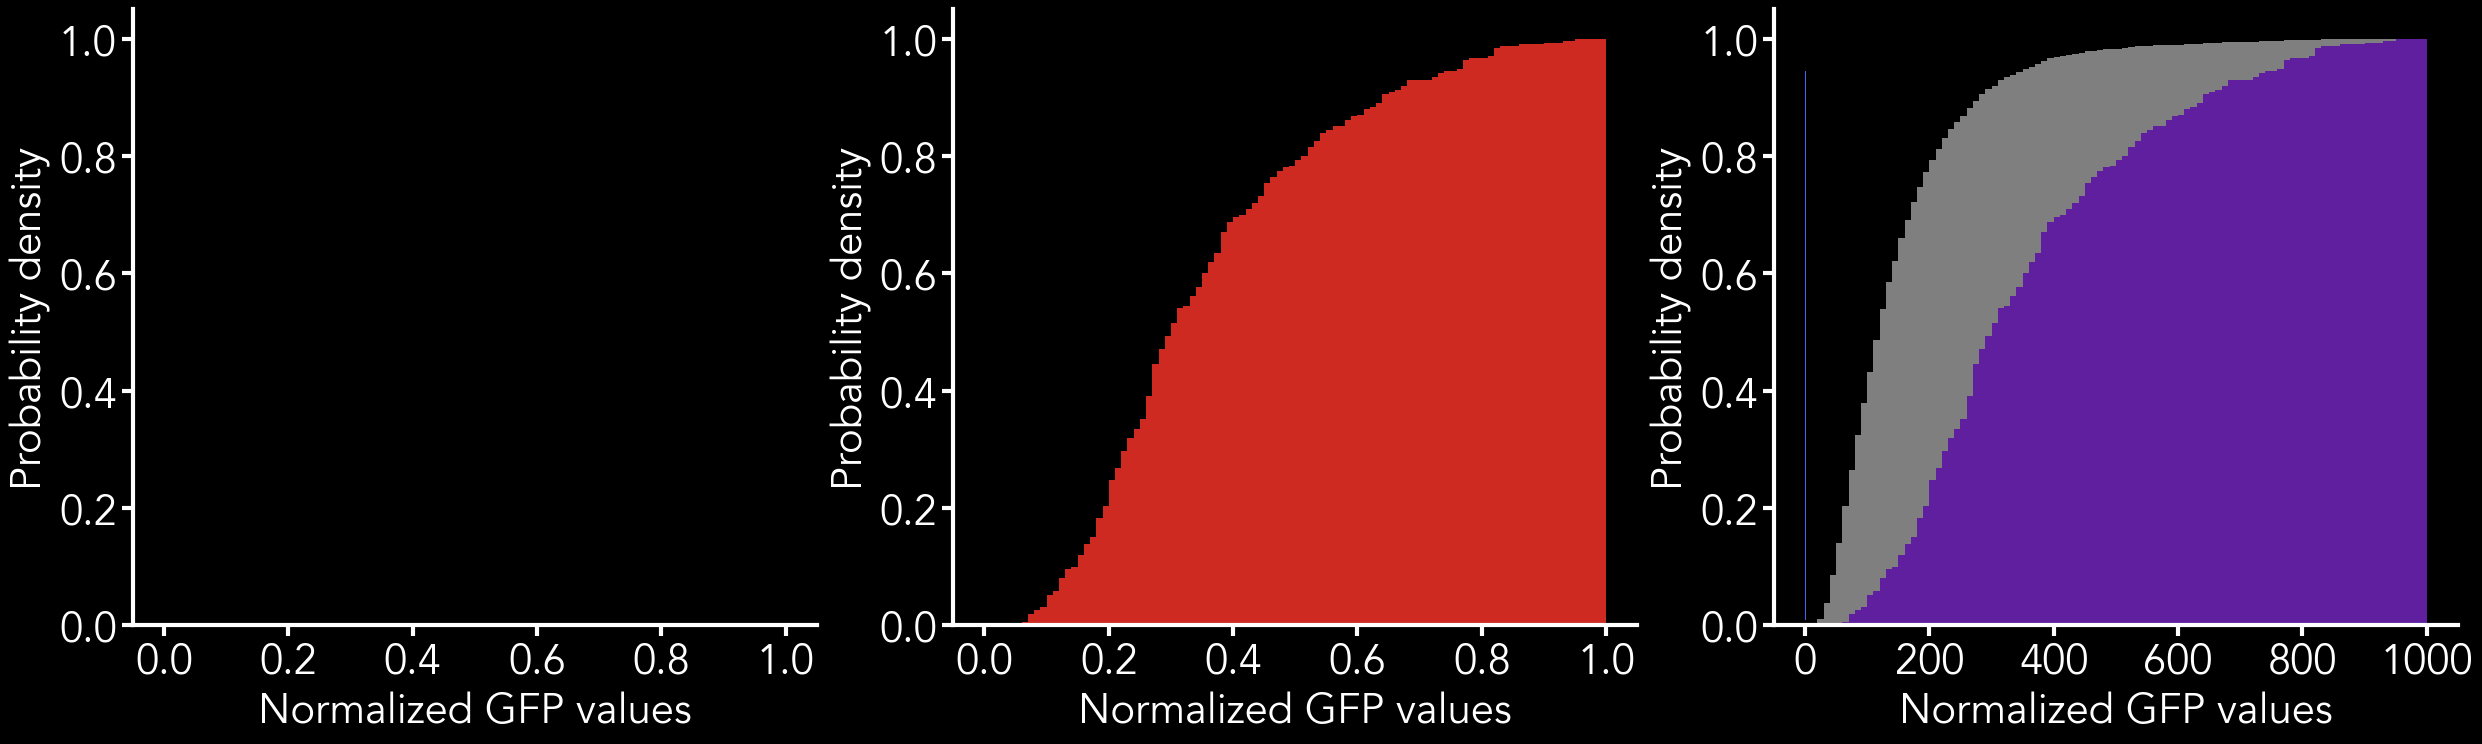

In [130]:
# collect all results
# analysis directory
dAnalysis = "D:/Analysis/20250202_Tbx2bhetinx_m2Gs2C/m2Gs2C/"
# dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/m2Gs2C/"

# wt_fPaths = [
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002",
#    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004" ,
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_004",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_004",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_004",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_004",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_004",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L09_004" ,
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_004",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004" 
#              ]


# # tbx2b
# gene = '';
# tbx2b_fPaths = [
#         "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004",
#                ]
# for fPath in tbx2b_fPaths:
#     GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)

    
# # tbx2a
# gene = '';
# tbx2a_fPaths = [
#    "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002",
#     "20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004",
#                ]


rName = 'sGtile'

wtResults = []
i=1;
for fPath in wt_fPaths:
    gene = ''
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
    wtResults.append(results[rName])
    i=i+1;

bResults = []
i=1;
for fPath in tbx2b_fPaths:
    gene = ''
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
    bResults.append(results[rName])
    i=i+1;


aResults = []
i=1;
for fPath in tbx2a_fPaths:
    gene = ''
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
    aResults.append(results[rName])
    i=i+1;


# combine across images
wtResults = np.concatenate(wtResults).ravel()
aResults = np.concatenate(aResults).ravel()
bResults = np.concatenate(bResults).ravel()

# plot histogram
pdfV = True
# wtH, wtB = np.histogram(wtResults, bins = 50, density=pdfV)
# aH, aB = np.histogram(aResults, bins = 50, density=pdfV)
# bH, bB = np.histogram(bResults, bins = 50, density=pdfV)

# plot histogram but first calculate a fixed bin number for all genotypes
# allBins = np.histogram_bin_edges(np.concatenate([wtResults,aResults,bResults]).ravel(),bins='fd');
allBins = np.arange(0,1010,10);
# allBins = np.histogram_bin_edges(np.concatenate([wtResults]).ravel(),bins='fd');
allBinsC = (allBins[:-1] + allBins[1:]) / 2 # Centers
wtH, wtB = np.histogram(wtResults, bins = allBins, density=pdfV)
aH, aB = np.histogram(aResults, bins = allBins, density=pdfV)
bH, bB = np.histogram(bResults, bins = allBins, density=pdfV)

# # this can be used for cumulative distribution then normalized
wtH = np.cumsum(wtH)/np.max(np.cumsum(wtH));
aH = np.cumsum(aH)/np.max(np.cumsum(aH));
bH = np.cumsum(bH)/np.max(np.cumsum(bH));

wt95CI = np.min(allBinsC[(np.cumsum(wtH))>.095])/1000;
wGBright = np.sum(wtH[allBinsC>wt95CI*1000]);
aGBright = np.sum(aH[allBinsC>wt95CI*1000]);
bGBright = np.sum(bH[allBinsC>wt95CI*1000]);

baseColor='#000000'
fH, (axH1,axH2,axH3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))
# fH = plt.figure(figsize=(30, 8))
# axH1 = plt.axes()
axH1.stairs(wtH,wtB/1000, fill=True, color = baseColor, alpha = 1.0)
axH2.stairs(wtH,wtB/1000, fill=True, color = baseColor, alpha = 0.5)
axH3.stairs(wtH,wtB/1000, fill=True, color = baseColor, alpha = 0.5)
axH2.stairs(aH,aB/1000, fill=True, color = zfC['lws1'], alpha = 1)
axH3.stairs(bH,bB/1000, fill=True, color = zfC['sws2'], alpha = 1)

axH1.plot([wt95CI,wt95CI],[0,0.008],color=baseColor)
axH2.plot([wt95CI,wt95CI],[0,0.008],color=baseColor)
axH3.plot([wt95CI,wt95CI],[0,0.008],color=baseColor)

formatFigureMain(fH, axH1, _)
formatFigureMain(fH, axH2, _)
formatFigureMain(fH, axH3, _)
# axH.set_title('Distribution of GFP inside L cones')
for axH in (axH1,axH2,axH3):
    axH.set_xlabel('Normalized GFP values')
    if pdfV:
        axH.set_ylabel('Probability density')
    else:
        axH.set_ylabel('Counts')
## normalized
axH.stairs(wtH/np.max(wtH),wtB, fill=True, color = 'white', alpha = 0.5)
axH.stairs(aH/np.max(aH),aB, fill=True, color = 'r', alpha = 0.5)
axH.stairs(bH/np.max(bH),bB, fill=True, color = 'b', alpha = 0.5)

# dPath = '/Users/angueyraaristjm/Documents/LiLab/Manuscripts/2021_zfConeRNAseq/resources/'
dPath = 'D:/Imaging/20250202_2bhetinx_s2C_m2G/'
# plt.savefig(dPath + "CRtbx2F0_SM_hist.svg", transparent=True, format="svg")

# print('# cells of bright GFP cells: wt={0}, tbx2a={1}, tbx2b={2}'.format(wGBright*1000,aGBright*1000,bGBright*1000))


print('# cells of bright GFP cells: wt={0}'.format(wGBright*1000,aGBright*1000,bGBright*1000))


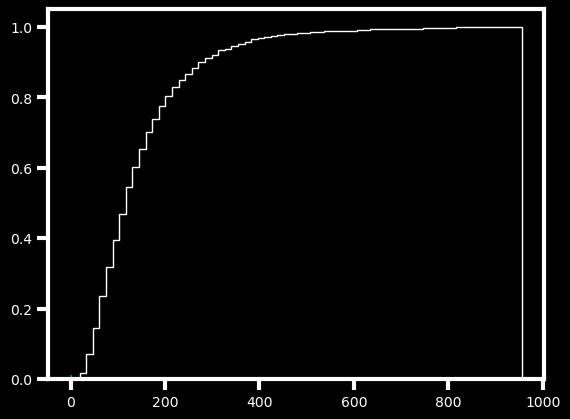

In [124]:
plt.stairs(wtH,wtB, color = 'white')
# plt.show()

plt.plot([wt95CI,wt95CI],[0,0.008],color='green')
plt.show()

### After establishing threshold based on all data, count number of cells exceeding threshold for each eye

In [ ]:
# collect all results
# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gs2C/"
# dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/m2Gs2C/"

wt_fPaths = [
       "20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_002"
   "20250123_5dpf_tbx2bhetinx_s2C_m2G_L01_004" 
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_002' 
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L02_004'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_002'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L03_004'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_002'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L04_004'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_002'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L05_004'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_002'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L06_004'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_002'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L07_004'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_002'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L08_004'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L09_004' 
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_002'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L10_004'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_002'
    '20250123_5dpf_tbx2bhetinx_s2C_m2G_L11_004' 
         ]
    
# # tbx2b
# gene = 'tbx2b';
# tbx2b_fPaths = [
        
#                ]

   
# # tbx2a
# gene = 'tbx2a';
# tbx2a_fPaths = [
        
#                ]


rName = 'sGtile'

wtResults = []
i=1;
for fPath in wt_fPaths:
    gene = 'wt'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
#     wtResults.append(np.count_nonzero(results['lGtile']>wt95CI*1000)) #this is for absolute counts
    wtResults.append(np.divide(np.count_nonzero(results['sGtile']>wt95CI*1000),len(results['sGtile']))) #this is for fraction
    i=i+1;

    
# aResults = []
# i=1;
# for fPath in tbx2a_fPaths:
#     gene = 'tbx2a'
#     dOut = dAnalysis + gene + '/' + fPath + '/'
#     results = np.load(dOut + 'quantificationGFP.npz')
# #     aResults.append(np.count_nonzero(results['lGtile']>wt95CI*1000)) #this is for absolute counts
#     aResults.append(np.divide(np.count_nonzero(results['sGtile']>wt95CI*1000),len(results['sGtile']))) #this is for fraction
#     i=i+1;

# bResults = []
# i=1;
# for fPath in tbx2b_fPaths:
#     gene = 'tbx2b'
#     dOut = dAnalysis + gene + '/' + fPath + '/'
#     results = np.load(dOut + 'quantificationGFP.npz')
# #     bResults.append(np.count_nonzero(results['lGtile']>wt95CI*1000)) #this is for absolute counts
#     bResults.append(np.divide(np.count_nonzero(results['sGtile']>wt95CI*1000),len(results['sGtile']))) #this is for fraction
#     i=i+1;

geneList = ['']


plotname = ''
fH, axH = plt.subplots(figsize= [6,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions


jitter = estimateJitter(wtResults)/400
pH = plt.bar([barStep+1/barD], np.mean(wtResults), width=1/barW, color=zfC['sws2']);
pH = plt.errorbar([barStep+1/barD], np.mean(wtResults), yerr = [[0.025],[np.std(wtResults)]], ecolor=lighten_color(zfC['sws2'],1), elinewidth=3, capsize=15, capthick=3, zorder=7)
pH = plt.scatter(np.ones(len(wtResults))*[barStep+1/barD]+jitter, wtResults, color=lighten_color(zfC['sws2'],.75), zorder=8, marker = zfGm['wt'], s=100, edgecolor='#000000', linewidth=0.5, alpha = .6);
barPos = np.append(barPos,(barStep+1/barD))



jitter = estimateJitter(aResults)/400
pH = plt.bar([barStep+2/barD], np.mean(aResults), width=1/barW, color=zfC['sws2']);
pH = plt.errorbar([barStep+2/barD], np.mean(aResults), yerr = [[0.025],[np.std(aResults)]], ecolor=lighten_color(zfC['sws2'],1), elinewidth=3, capsize=15, capthick=3, zorder=7)
pH = plt.scatter(np.ones(len(aResults))*[barStep+2/barD]+jitter, aResults, color=lighten_color(zfC['sws2'],.75), zorder=8, marker = zfGm['tbx2a'], s=100, edgecolor='#000000', linewidth=0.5, alpha = .6);
barPos = np.append(barPos,(barStep+2/barD))

jitter = estimateJitter(bResults)/400
pH = plt.bar([barStep+3/barD], np.mean(bResults), width=1/barW, color=zfC['sws2']);
pH = plt.errorbar([barStep+3/barD], np.mean(bResults), yerr = [[0.025],[np.std(bResults)]], ecolor=lighten_color(zfC['sws2'],1), elinewidth=3, capsize=15, capthick=3, zorder=7)
pH = plt.scatter(np.ones(len(bResults))*[barStep+3/barD]+jitter, bResults, color=lighten_color(zfC['sws2'],.75), zorder=8, marker = zfGm['tbx2b'], s=100, edgecolor='#000000', linewidth=0.5, alpha = .6);
barPos = np.append(barPos,(barStep+3/barD))

fontProps = formatFigureMain(fH, axH, pH)

# axH.set_ylabel('GFP+ L cones per 64 x 64 $\mu$m$^2$', fontproperties=formatFigureMain(fH, axH, pH))
# axH.set_ylim([0,180]);
# stath = 170

axH.set_ylabel('Fraction of GFP+ S cones', fontproperties=fontProps)
axH.set_ylim([0,1]);
stath = 0.98

geneList = ['control','F$\emptyset$[tbx2a]','F$\emptyset$[tbx2b]']

axH.xaxis.set_tick_params(rotation=45)
axH.set_xticks(np.sort(barPos));
axH.set_xticklabels(geneList);

hH = plt.hlines(stath, barPos[0], barPos[2], colors='#000000',linewidth=4)
plt.text((barPos[0]+barPos[2])/2, stath, '*', font_properties=fontProps, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")


dPath = 'D:/Imaging/20250202_2bhetinx_s2C_m2G/'
# dPath = '/Users/angueyraaristjm/Documents/LiLab/Presentations/revealjs/resources/20211008_UCLA/'
# plt.savefig(dPath + "CRtbx2F0_GFPScones.svg", transparent=True, format="svg")

print('Threshold (5%) is {0}'.format(wt95CI))